In [72]:
import pathlib
import sys

import numpy as np
import skimage
import tifffile
from tqdm import tqdm
from matplotlib import pyplot as plt
import pandas as pd

sys.path.append("../src/")
import image_utils  # noqa

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load all of the raw images

These are the TIFFs produced by `convert_nd2.py` script using:
```sh
python scripts/convert_nd2.py convert-dir 
    --input-dirpath ~/data/s3-cache/2024-worm-motility \
    --output-dirpath processed-data/2024-worm-motility 
```

In [74]:
# Find all of the tiff files in the data directory.
data_dirpath = pathlib.Path("../processed-data/2024-worm-motility").absolute()
filepaths = [
    dirpath / filename
    for dirpath, _, filenames in data_dirpath.walk()
    for filename in filenames
    if filename.endswith(".tiff")
]

filepaths = sorted(filepaths)
len(filepaths)

79

In [ ]:
filepaths[47:]

In [75]:
# Count the number of FOVs per dataset.
pd.Series([str(pathlib.Path(filepath.parent.name)) for filepath in filepaths]).value_counts()

20240523_125303_976          22
20240523_110843_211          20
20240523_112538_444           5
20240612_090658_375_L2        2
20240620_102156_815_crb1      2
20240620_100452_170_pdl1      2
20240620_094534_967_arr1      2
20240614_095331_595_adult     2
20240613_085645_456_L4        2
20240612_161113_448_L3        2
20240531_104851_398           2
20240611_131803_922_L1        2
20240531_101742_080           2
20240531_100411_482           2
20240531_095010_646           2
20240528_130755_875           2
20240528_114422_892           2
20240528_104902_674           2
20240620_103631_144_osm12     2
Name: count, dtype: int64

In [76]:
# Load all of the images (this is a little slow; it could be parallelized).
raw_ims = [tifffile.imread(filepath) for filepath in tqdm(filepaths)]
len(raw_ims)

  0%|          | 0/79 [00:00<?, ?it/s]

100%|██████████| 79/79 [01:04<00:00,  1.23it/s]


79

## Exploratory visualization

In [77]:
# Create min-intensity projections of all FOVs and stack them into a single array.
raw_ims_proj = np.stack([image_utils.autoscale(im.min(axis=0), percentile=99.9) for im in raw_ims])
raw_ims_proj.shape

(79, 512, 512)

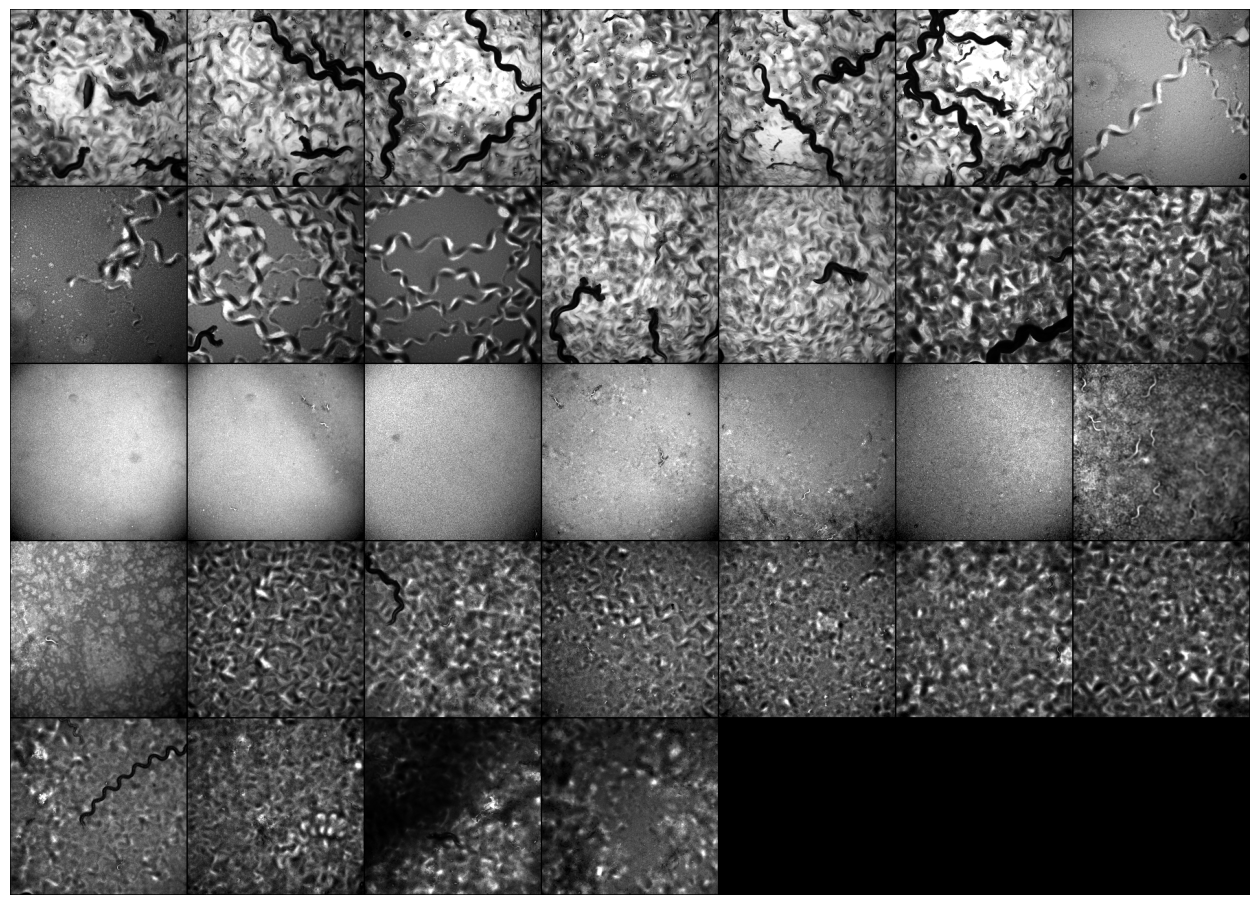

In [83]:
post_2024_05_23_ind = 47
tiled_image = image_utils.tile_images_2d(raw_ims_proj[post_2024_05_23_ind:], num_rows=5)
image_utils.imshow(tiled_image, figsize=(16, 16))

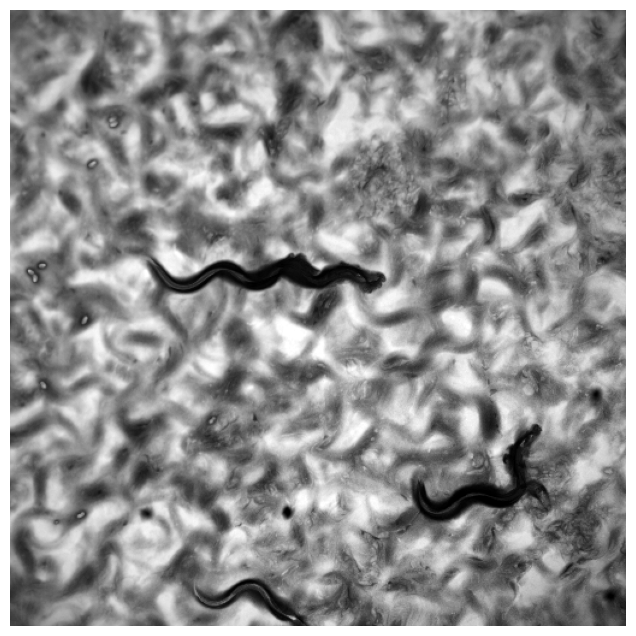

In [11]:
# Inspect single FOVs in the tiled array (I manually counted to figure out the index).
ind = -3
image_utils.imshow(raw_ims_proj[ind, :, :], figsize=(8, 8))

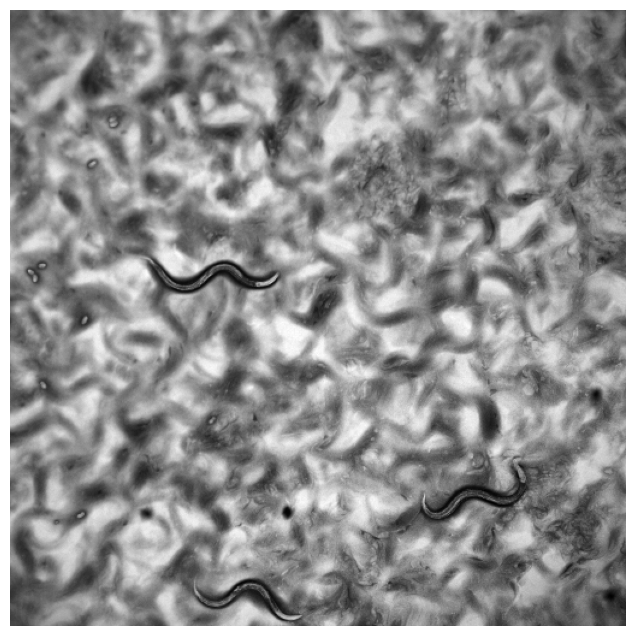

In [36]:
# Inspect single FOVs in the tiled array (I manually counted to figure out the index).
ind = -3
image_utils.imshow(raw_ims[ind][0, :, :], figsize=(8, 8))

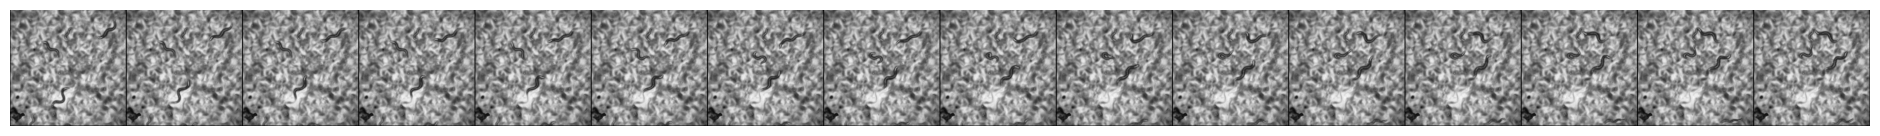

In [28]:
# View a subsample of the frames in a single FOV as a 1D tiled array.
ind = 7
image_utils.imshow(image_utils.tile_images_1d(raw_ims[ind], num_timepoints=15), figsize=(24, 3))

In [84]:
# Hand-picked indices of example FOVs for each category.
example_inds = {
    "in-focus": (44, 16),
    "out-of-focus": (7, 12),
    "stationary-worms": (37, 39),
}


def get_example(name, num=None):
    """Convenience function to get an example image by name."""
    for key in example_inds.keys():
        if name in key:
            ind = example_inds[key][num if num is not None else 0]
            return raw_ims[ind].copy()

## Background subtraction

This section reimplements the background subtraction in `background_subtraction_pharaglow.py`.

In [85]:
def subtract_background(im, subsample_by=10):
    """
    Subtract the mean intensity across the first dimension (time) from each frame.
    Since most of the background is unchanging, except for where the worm crawls,
    this has the effect of removing most of the background.

    TODO: it also has the effect of removing worms that don't move.
    """
    if im.ndim < 3:
        raise ValueError("Input must be a 3D array with dimensions (time, x, y).")

    im = im.astype(np.float32)
    # Use the mean instead of the median because it is faster to compute.
    im -= np.mean(im[::subsample_by, :, :], axis=0)
    im = image_utils.autoscale(im, percentile=100)
    return im

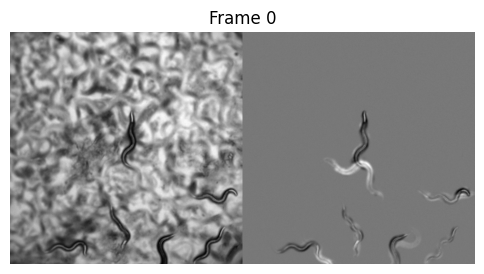

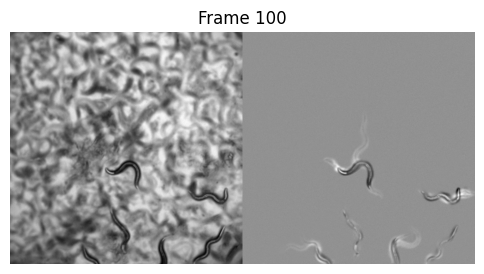

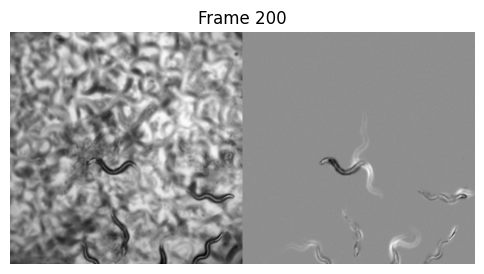

In [86]:
# View an example FOV before and after background subtraction.
im_raw = get_example("in", 1)
im_bgs = subtract_background(im_raw)

for ind in (0, 100, 200):
    image_utils.imshow(im_raw[ind, :, :], im_bgs[ind, :, :], figsize=(6, 6), title=f"Frame {ind}")

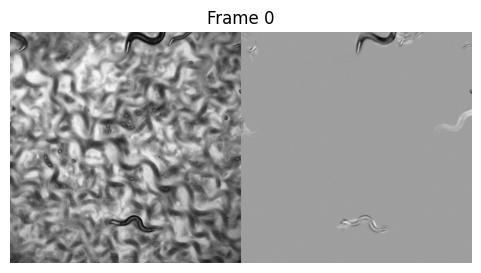

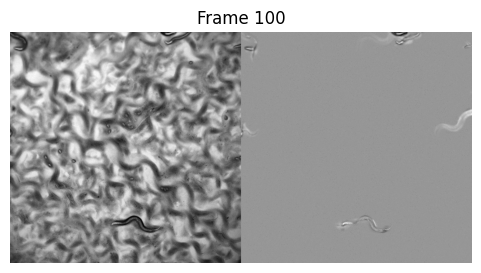

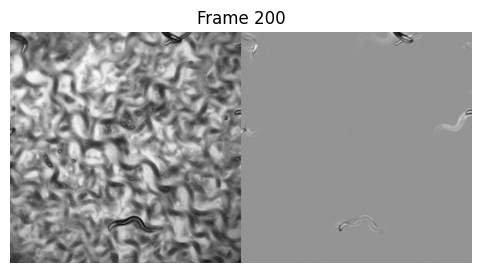

In [87]:
# View an example FOV stationary worms.
im_raw = get_example("stationary", 0)
im_bgs = subtract_background(im_raw)

for ind in [0, 100, 200]:
    image_utils.imshow(im_raw[ind, :, :], im_bgs[ind, :, :], figsize=(6, 3), title=f"Frame {ind}")

### Aside: background subtraction using a windowed mean

This does not work very well, because decreasing the window size is roughly equivalent to decreasing the "speed" of the worm, and the slower the worms, the fainter they become after background subtraction.

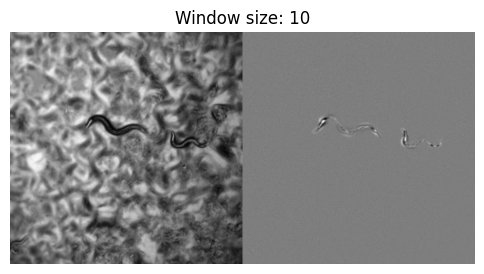

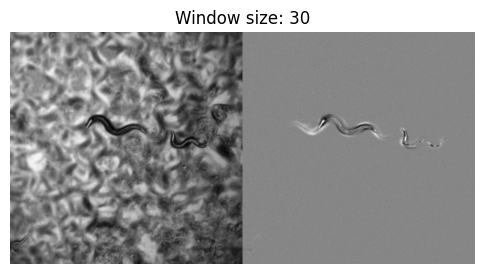

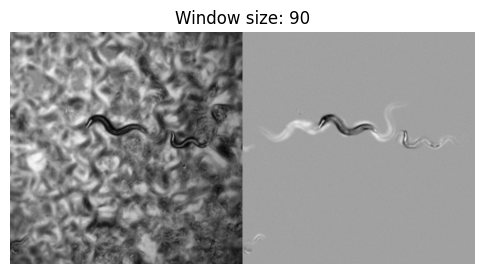

In [30]:
im_raw = get_example("in", 1)

# View the effect of windowed background subtraction on a single frame
# in the middle of the timelapse, using a few different window sizes.
ind = 100
for window in (10, 30, 90):
    im_cropped = im_raw[ind - window : ind + window + 1, :, :].copy()
    im_bgs = subtract_background(im_cropped, subsample_by=3)
    image_utils.imshow(
        im_cropped[window, :, :],
        im_bgs[window, :, :],
        figsize=(6, 6),
        title=f"Window size: {window}",
    )

## Generating a background mask from the standard deviation across time

The logic of this is that because the true background is unchanging, we can create an approximate mask of the background by taking the standard deviation of the pixel values across time. 

This mask will be imperfect, since some worms don't move much or at all, but it is still useful as a way to estimate background intensity in later steps.

In [73]:
def make_background_mask_from_standard_deviation(im, ind=None):
    """
    Create a binary mask of the background based on the standard deviation of the image.
    """
    if im.ndim < 3:
        raise ValueError("Input image must have at least 3 dimensions.")

    subsample_by = 3
    window = 30
    if ind is not None:
        im = im[max(0, ind - window) : min(ind + window, len(im)), :, :]
        subsample_by = 1

    std = im[::subsample_by, :, :].std(axis=0)
    thresh = skimage.filters.threshold_otsu(std)
    mask = std > thresh
    return std, mask

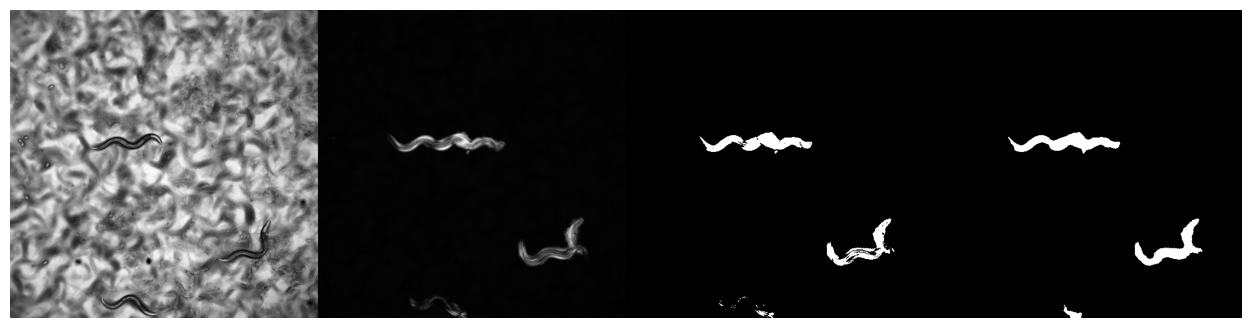

In [74]:
im = get_example("in", 0)

ind = 100
std, mask = make_background_mask_from_standard_deviation(im, ind=None)
image_utils.imshow(im[ind, :, :], std, mask, image_utils.cleanup_mask(mask), figsize=(16, 4))

## Generating a frame-wise background mask

This means generating a binary image where the background is white and the foreground is black. The white regions should correspond to the worms, and the black regions should correspond to the background.

### Generating a frame-wise background mask *after* background subtraction

This appears to be pretty easy: the background-subtracted frames are so clean that a simple thresholding operation is enough to generate a relatively clean frame-wise background mask.

But it has some problems: stationary worms are lost, and the "ghosting" around mobile worms degrades the quality of the background mask.

In [15]:
def make_background_mask_from_background_subtraction(im):
    """
    Create a binary mask of the background based on the background-subtracted image
    using a simple intensity threshold.
    """
    frame_bgs_smooth = skimage.filters.gaussian(im, sigma=1)
    thresh = skimage.filters.threshold_otsu(frame_bgs_smooth)
    mask = frame_bgs_smooth < thresh
    return mask

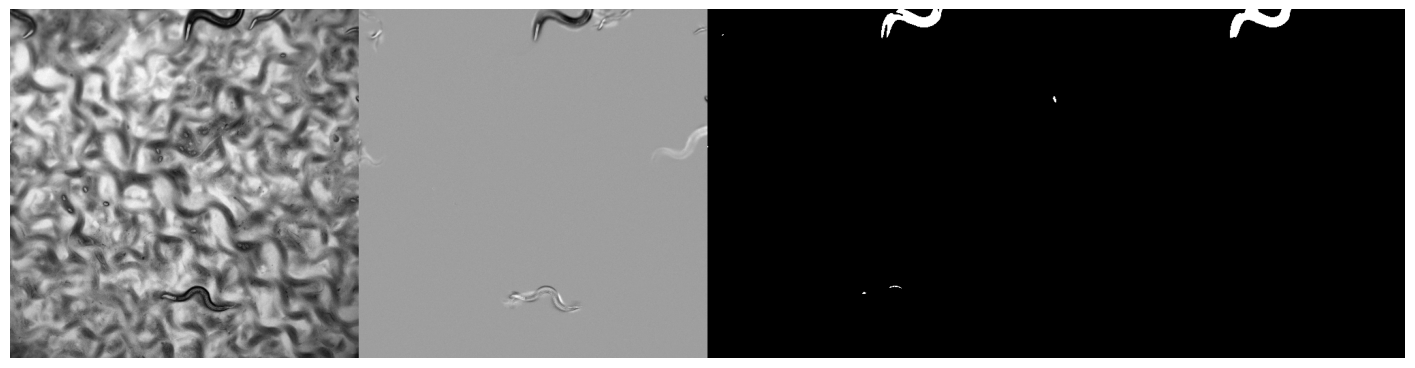

In [16]:
im = get_example("st", 1)
im_bgs = subtract_background(im)

frame = im[0, :, :]
frame_bgs = im_bgs[0, :, :]

mask = make_background_mask_from_background_subtraction(frame_bgs)
image_utils.imshow(frame, frame_bgs, mask, image_utils.cleanup_mask(mask), figsize=(18, 6))

### Generating a background mask *without* background subtraction

The logic of attempting to do this is that it would capture stationary worms and it would avoid the "ghosting" around mobile worms that results from the background subtraction.

In [71]:
def make_background_mask(frame, estimated_background_mask):
    """
    Create a binary mask of the background by thresholding the standard deviation of the image.
    """
    # Use a DoG filter to enhance the edges of the worms.
    # This works by supressing the blurry, low-spatial-frequency background
    # relative to the sharp, high-frequency edges of the worms.
    dog_filtered = skimage.filters.difference_of_gaussians(frame, low_sigma=0.3, high_sigma=3)

    # A built-in skimage filter to find edges seems to work the best.
    # Reference: https://scikit-image.org/docs/stable/auto_examples/edges/plot_ridge_filter.html#ridge-operators.
    edges = skimage.filters.sato(dog_filtered, sigmas=[0.3, 1], black_ridges=True)

    # Find a threshold for the edges using Otsu's method and the estimated background mask.
    thresh = skimage.filters.threshold_otsu(edges[estimated_background_mask])
    mask = edges > thresh

    return mask, dog_filtered, edges

In [75]:
im = get_example("st", 1)
_, mask_from_std_dev = make_background_mask_from_standard_deviation(im)

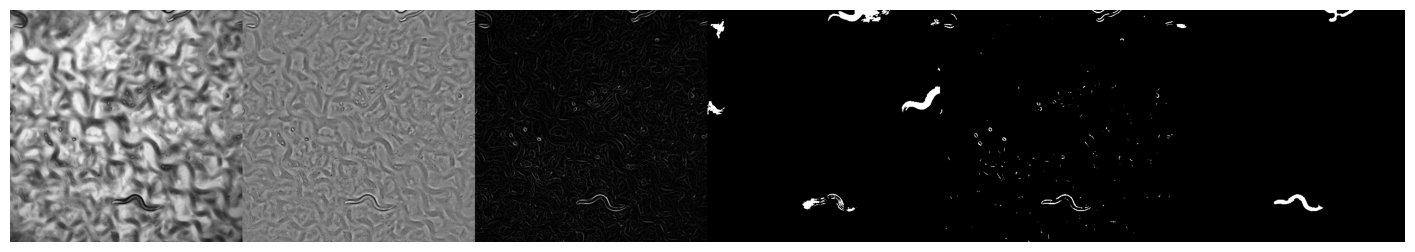

In [76]:
frame = im[99, :, :]

mask, dog_filtered, edges = make_background_mask(frame, estimated_background_mask=mask_from_std_dev)
image_utils.imshow(
    frame,
    dog_filtered,
    edges,
    mask_from_std_dev,
    mask,
    image_utils.cleanup_mask(mask),
    figsize=(18, 6),
)

### Tierpsy-tracker's getROIMask method

This appears to be how tierpsy-tracker generates a background mask.

In [37]:
sys.path.append("../src/third_party/tierpsy_tracker/")
from get_roi_mask import getROIMask

In [45]:
im = get_example("in", 0)
im_bgs = subtract_background(im)

In [46]:
frame = im[100, :, :]
frame = image_utils.autoscale(frame, dtype=np.uint8)

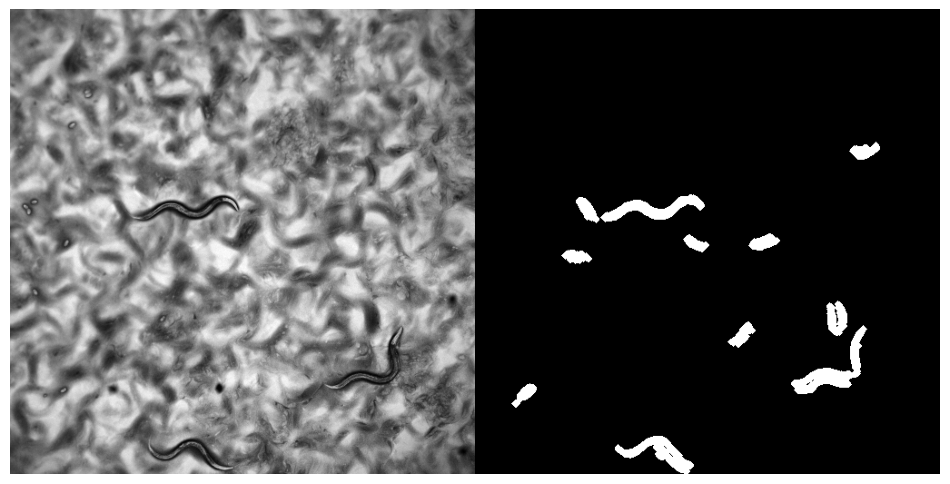

In [56]:
mask = getROIMask(
    frame,
    min_area=100,
    max_area=1000,
    thresh_block_size=9,
    thresh_C=13,
    dilation_size=3,
    keep_border_data=False,
    is_light_background=True,
)

image_utils.imshow(frame, mask)

## Aside: segmentation mask for an example image with a lighter, less contrasty background

This is a screenshot from Fig 1 of Deserno et al. 2023 ("WormSwin: Instance segmentation of C. elegans using vision transformer").

In [33]:
screenshot = skimage.io.imread("../processed-data/screenshot-from-2023-deserno.png")
# The screenshot is grayscale and way over-sampled,
# so we downsample by 3x and take the blue channel.
screenshot = screenshot[::3, ::3, 2]

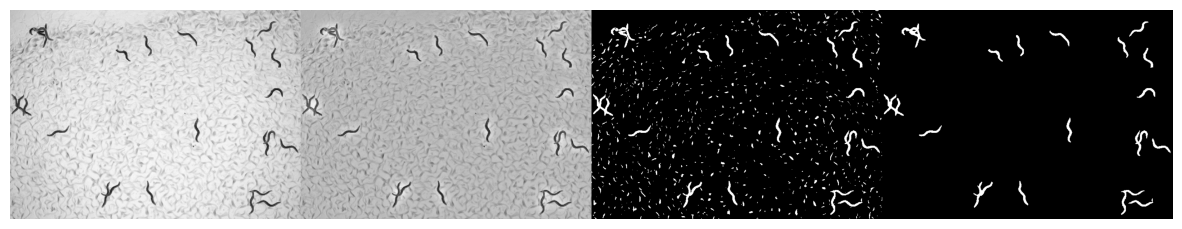

In [34]:
screenshot_filtered = skimage.filters.difference_of_gaussians(
    screenshot, low_sigma=0.3, high_sigma=10
)

thresh = skimage.filters.threshold_otsu(screenshot_filtered)
mask = screenshot_filtered < thresh

image_utils.imshow(
    screenshot,
    screenshot_filtered,
    mask,
    image_utils.cleanup_mask(mask, closing_radius=1, min_region_size=100),
    figsize=(15, 15),
)

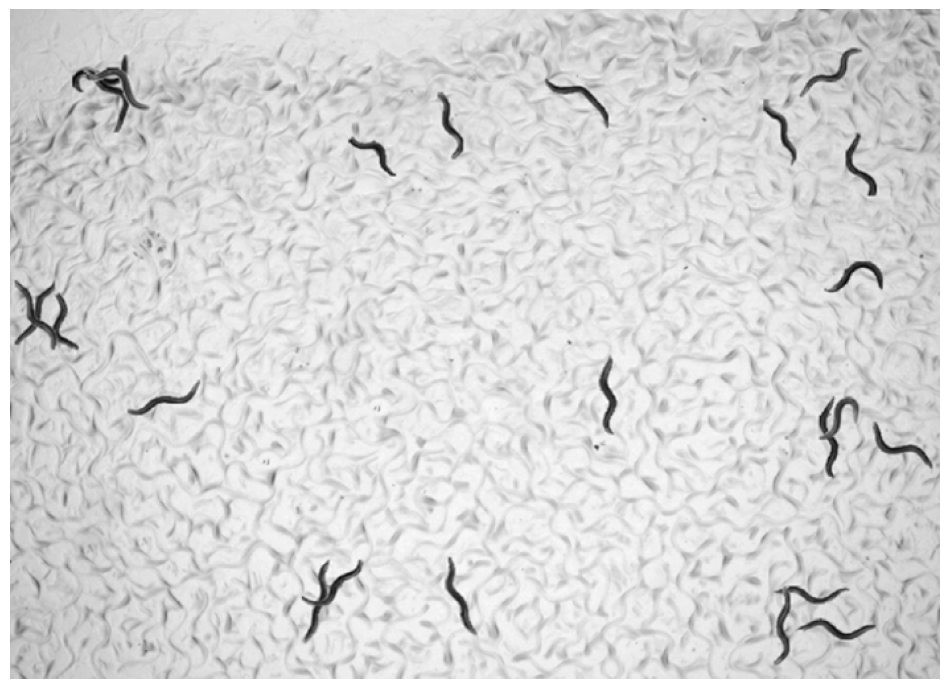

In [35]:
image_utils.imshow(screenshot)